# Exercise 2

Exercise 2 includes a **written assignment** (10 points), a **programming assignment with 4 problems** (9 points) and a **feedback/workload assessment assignment** (1 point). For each problem you need to modify the notebook by adding your own programming solutions or written text. Remember to save and commit your changes locally, and push your changes to GitHub after each major change! Regular commits will help you to keep track of your changes (and revert them if needed). Pushing your work to GitHub will ensure that you don't lose any work in case your computer crashes (can happen!).

### Due date

This exercise should be returned to your personal Github repository **within two weeks** after it has been released (by Thursday February 3rd at 23:59). Please notice that finishing the programming exercises can take significant amount of time (especially if you don't have yet much programming experience). Hence, it is recommended that you start immediately working on them.

# Exercise 2 - Written assignment (10 points)

In the *Human wellbeing and capabilities* and *Network analytics and spatial accessibility modelling* lessons this week, we went through concepts related to equity, justice and spatial accessibility and learned how spatial network analysis can be used to quantify access. 


## Equity and accessibility

Write approx. 0.5-2 pages (A4) of text in English where you explain:
 
 - How philosophies of justice and concept of accessibility relate to each other?
   - how justice and equity can be understood (e.g. Rawlsian view)?
 - How spatial accessibility can be modelled and what kind of application areas there exists?
 - How equity and spatial accessibility modelling relates to sustainability?
 
Use the lesson materials and the recommended readings (optional) as a source of information for answering to these.

----------------

### My answer

**Add your text here.**

*Hint: To "activate" this cell in Editing mode, double click this cell. If you want to get this cell back in the "Reading-mode", press Shift+Enter.*


## Hints

- If you need help in Markdown formatting (e.g. how to add headings, bold, italics, links etc.), please take a look at this excellent [guide / cheatsheet](https://www.markdownguide.org/cheat-sheet/) 

# Exercise 2 - Programming assignment

In this exercise, we will practice network analysis and spatial accessibility modelling. Our overall goal is to analyze healthcare accessibility by conducting a two-step floating catchment area analysis in Helsinki Region. We will calculate travel time-based catchment areas by driving (10 minutes threshold) from selected hospitals and postal code areas in the Helsinki Region. Based on the population information and the number of physicians at given hospital (simulated --> not real), we can calculate an accessibility index based on 2SFCA method. The end result should look something like following:

!["Healthcare accessibility map in Helsinki Region](img/hospital_accessibility_2SFCA_HelsinkiRegion.PNG)
  
The main point in this Exercise is to practice how to do network analysis in Python, and use it for a practical health-related research question. Similar approaches can be used for many different applications that require understanding supply and demand of some kind of service (can be e.g. commercial application as well).

### Start your exercise in CSC Notebooks

Before you can start programming, you need to launch the CSC Notebook instance and clone your Exercise repository there.
If you need help with this, [read the documentation on the course site](https://sustainability-gis.readthedocs.io/en/latest/lessons/L1/git-basics.html).
 
### Hints 

If there are general questions arising from this exercise, we will add hints to the course website under [Exercise 2 description](https://sustainability-gis.readthedocs.io/en/latest/lessons/L2/exercise-2.html). 

## Input data for the exercise

We will use only openly available data sources for this exercise, listed below.

### Healthcare facilities and number of physicians 

We will use the real locations of healthcare facilities in Helsinki Region (based on data from [Palvelukartta](https://palvelukartta.hel.fi/fi/)) and **simulated** data about the number of doctors working in them. The distribution of the number of doctors working in different facilities looks like this (the size of the bubble corresponds the number of physicians):
![The proportion of doctors in different health facilities](img/Number_of_doctors_in_hospitals_simulated.PNG)

Notice that this data **is not real** and it has been simulated based on openly available data/information and has many assumptions (e.g. that the number of doctors in cities reflect the average of whole Finland which is 3.8 doctors per 1000 inhabitants). The physicians are allocated to different facilities based on relative number of health-related employees working at different postal code areas (again a big assumption). These steps have been taken to make the data a bit more realistic, but they cannot be considered to reflect reality. If you are interested to see the details of how the data was produced based on open data, [check this notebook](https://github.com/AaltoGIS/data-preparations/blob/master/Preparing_hospital_data.ipynb). 

### Population distribution

The population data that we will use in this exercise is openly available from [HSY](https://www.hsy.fi/en/environmental-information/open-data/avoin-data---sivut/population-grid-of-helsinki-metropolitan-area/). The data is from 2019 and it has been cleaned, so it is ready for you to use. The column `ASUKKAITA` contains information about the number of inhabitants in given grid cell. The population distribution in Helsinki looks like following:

![Population distribution](img/Number_of_inhabitants_Helsinki_Region_2019.PNG)

### Postal code areas

The final 2SFCA indices will be calculated on a postal code level (to reduce the amount of routings that are needed). We will use openly available data from Statistics Finland (PAAVO) and fetch the postal code level data using [WFS API](https://www.stat.fi/org/avoindata/paikkatietoaineistot/paavo_en.html).

### Street network

For street networks and conducting the accessibility analysis, we will use OpenStreetMap data using `pyrosm`. 

## Problem 1 - Prepare network data for routing (3 points)

In this problem, we prepare a routable graph for our analysis. You should:

  1. read drivable roads (edges and nodes) for Helsinki Region using `pyrosm`
  2. fill speed limit information (`maxspeed`) for roads which miss that information
  3. calculate drive time in seconds for each edge
  4. create a directed `Networkx` graph based on the nodes and edges using `pyrosm`
 
 
Based on the road network edges, answer to following questions:

 - What is the average length of road distances?
     - Answer: 18.069 m
 - What is the average travel time (in seconds) of road segments? (considering all roads)
     - Answer: 1.851 s
 - What is the "longest" road segment to travel in terms of travel time (in seconds)? 
     - Answer: 87.186 s
 

Please write your solution to the cell below (remove the `raise NotImplementedError()` code). You can create new cells as well if needed.

In [2]:
# YOUR CODE HERE
import pyrosm
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox

# Helper function borrowed from the tutorial 2 on this course
def road_class_to_kmph(road_class):
    """
    Returns a speed limit value based on road class, 
    using typical Finnish speed limit values within urban regions.
    """
    if road_class == "motorway":
        return 100
    elif road_class == "motorway_link":
        return 80
    elif road_class in ["trunk", "trunk_link"]:
        return 60
    elif road_class == "service":
        return 30
    elif road_class == "living_street":
        return 20
    else:
        return 50

    
# read drivable roads (edges and nodes) for Helsinki Region using pyrosm
# init reader
fp = pyrosm.get_data("Helsinki")
osm = pyrosm.OSM(fp)

# read nodes and edges of driving network
nodes, edges = osm.get_network(nodes=True, network_type="driving")

# remove pedestrian roads
edges = edges.loc[~edges["highway"].isin(['cycleway', 'footway', 'pedestrian', 'trail', 'crossing'])].copy()

# fill speed limit information (maxspeed) for roads which miss that information
edges["maxspeed"].value_counts(dropna=False)
edges["maxspeed"] = edges["maxspeed"].astype(float).astype(pd.Int64Dtype())

# use mask to select null maxspeed edge rows and valid rows
mask = edges["maxspeed"].isnull()
edges_null_maxspeed = edges.loc[mask].copy()
valid_edges = edges.loc[~mask].copy()

# use the helper function to assing missing maxspeed values
edges_null_maxspeed["maxspeed"] = edges_null_maxspeed["highway"].apply(road_class_to_kmph)
edges_null_maxspeed.head(5).loc[:, ["maxspeed", "highway"]]

# combine the split edge gdfs
edges = valid_edges.append(edges_null_maxspeed)

# calculate drive time in seconds for each edge
edges["travel_time_seconds"] = edges["length"] / (edges["maxspeed"]/3.6)
edges = edges[["oneway", "travel_time_seconds", "length", "u", "v", "geometry"]]


# create a directed Networkx graph based on the nodes and edges using pyrosm
G = osm.to_graph(nodes, edges, graph_type="networkx")


# Based on the road network edges, answer to following questions:
# What is the average length of road distances?
print("The average length of road distances is: {:.3f} m".format(edges["length"].mean()))

# What is the average travel time (in seconds) of road segments? (considering all roads)
print("The average travel time (in seconds) of road segments is: {:.3f} s".format(edges["travel_time_seconds"].mean()))

# What is the "longest" road segment to travel in terms of travel time (in seconds)?
print("the longest road segment to travel in terms of travel time is: {:.3f} s".format(edges["travel_time_seconds"].max()))


The average length of road distances is: 18.069 m
The average travel time (in seconds) of road segments is: 1.851 s
the longest road segment to travel in terms of travel time is: 87.186 s


## Problem 2 - Prepare other datasets for the analysis (2 points)

In this problem, you should read following files to geopandas:
 
  1. read population grid (250 m resolution) which is available in `data` directory (population_grid_hsy.geojson)
  2. hospital data to variable **hospitals** (also in `data` directory) including information about the number of physicians at a given health care facility (hospital_data.geojson)
  3. postal code level data from Statistics Finland using their WFS service
     - hint: you can read postalcode data easily with geopandas `read_file()` function by passing a following url into it: `'http://geo.stat.fi/geoserver/postialue/wfs?request=GetFeature&typename=postialue:pno_tilasto_2019&outputformat=JSON'` 
  4. Reproject all the previous layers (1-3 above) to WGS84 coordinate reference system
  

  
After you have read the data, you should do following steps:

 5. Drop healthcare centers from the hospital data: From **hospitals** dataset select only rows where the `service_en` is either `"university hospitals"` or `"city or municipal hospitals"`
 6. Create a **copy** of the population grid data into a new variable `pop_centroids` and convert the Polygon geometries to Points using `centroid`
 7. The postal code data is covering whole Finland. Select only postal code areas covering Helsinki, Espoo, Vantaa and Kauniainen. 
    - A hint: you might want to use [municipality codes - kunta](https://www.tilastokeskus.fi/fi/luokitukset/kunta/) to filter the data
 8. For **postal code** data (from PAAVO), calculate the centroid of the geometries into a column `centroid` and set it as an active geometry for the GeoDataFrame.
    - **hint:** You can use `gpd.set_geometry()` function to specify which geometry is "active" in the data (i.e. which is used e.g. for plotting or when doing spatial selection etc.)
    - **note:** You can ignore the possible UserWarning related to using geographic CRS when calculating the centroid.
    
    
Please write your solution to the cell below (remove the `raise NotImplementedError()` code). You can create new cells as well if needed.

   ASUKKAITA                                           geometry
0          5  POLYGON ((24.50287 60.28562, 24.50284 60.28787...
1          8  POLYGON ((24.50311 60.26992, 24.50308 60.27216...
2          5  POLYGON ((24.50315 60.26767, 24.50311 60.26992...
3         12  POLYGON ((24.50328 60.25870, 24.50325 60.26094...
4          5  POLYGON ((24.50682 60.32378, 24.50678 60.32603...
   ASUKKAITA                   geometry
0          5  POINT (24.50512 60.28675)
1          8  POINT (24.50535 60.27105)
2          5  POINT (24.50539 60.26880)
3         12  POINT (24.50552 60.25983)
4          5  POINT (24.50906 60.32491)


/tmp/ipykernel_105/3281696875.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pop_centroids["geometry"] = pop_centroids["geometry"].centroid
Unable to revert mtime: /opt/conda/fonts


<AxesSubplot:>

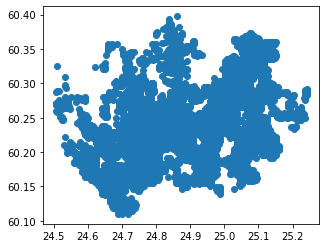

In [7]:
# YOUR CODE HERE
import geopandas as gpd


# read population grid (250 m resolution) which is available in data directory (population_grid_hsy.geojson)
population_grid = gpd.read_file("data/population_grid_hsy.geojson")

# hospital data to variable hospitals including information about the number of physicians at a given health care facility (hospital_data.geojson)
hospitals = gpd.read_file("data/hospital_data.geojson")

# postal code level data from Statistics Finland using their WFS service
postal = gpd.read_file("http://geo.stat.fi/geoserver/postialue/wfs?request=GetFeature&typename=postialue:pno_tilasto_2019&outputformat=JSON")

# Reproject all the previous layers to WGS84 coordinate reference system
population_grid_wgs = population_grid.to_crs("EPSG:4326")
hospitals_wgs = hospitals.to_crs("EPSG:4326")
postal_wgs = postal.to_crs("EPSG:4326")


# Drop healthcare centers from the hospital data
hospitals_wgs = hospitals_wgs[hospitals_wgs.service_en.isin(["university hospitals", "city or municipal hospitals"])]

# Create a copy of the population grid data into a new variable pop_centroids and convert the Polygon geometries to Points using centroid
pop_centroids = population_grid_wgs.copy()
pop_centroids["geometry"] = pop_centroids["geometry"].centroid

# TODO The postal code data is covering whole Finland. Select only postal code areas covering Helsinki, Espoo, Vantaa and Kauniainen.
# A hint: you might want to use municipality codes - kunta to filter the data


# TODO For postal code data (from PAAVO), calculate the centroid of the geometries into a column centroid and set it as an active geometry for the GeoDataFrame.
# hint: You can use gpd.set_geometry() function to specify which geometry is "active" in the data (i.e. which is used e.g. for plotting or when doing spatial selection etc.)
# note: You can ignore the possible UserWarning related to using geographic CRS when calculating the centroid.



## Problem 3 - Calculate 10 minute catchment areas for hospitals and calculate PPR (2 points)

In this problem, we do the **first step** of "two-step floating catchment area" method. Hence, you should: 

 1. calculate a catchment area for each hospital (n=27) based on the routable graph (by driving) that was created in Problem 1 (you need to loop over hospitals). You should use Networkx to do the calculations. See the Tutorial materials to understand what are the required steps. **You should calculate the travel times only up to 10 minutes** (i.e. 600 seconds). Note: It will take awhile to calculate these.
   - **Hint: Before looping over all hospitals it is MUCH RECOMMENDED to first iterate over e.g. a couple of hospitals to see that things are working as should.** This is one of the good coding practices: test with a small sample before running a longer calculation (it saves times and nerves). 
 2. Make a spatial join between the **population grid** (i.e. the HSY population distribution data) and the network **nodes** that come as a result with the given 10 minute catchment area, and store it into a variable. As a result you should have something like following, in which specific population grid cells are selected if they intersect with the network nodes (10 minute catchment area): 
 
 ![Spatial join between nodes and pop grid](img/network_nodes_intersecting_population_grid.PNG)
 
 3. Calculate the total sum of inhabitants living under the catchment area (use `ASUKKAITA` column in the population grid) and store it into a variable
 4. From the row of the given hospital (which you are iterating) get the number of physicians and store it into a variable (convert it into an integer)
 5. Calculate the prover-to-population ratio by dividing the number of physicians by the population sum within given catchment, and store it into a variable. 
 6. Convert the selected the grid cells fell within the catchment area into a MultiPolygon by making an unary union the Polygon geometries (check geopandas *unary_union*). After this step, you should get a single shapely geometry instead of multiple rows of data in GeoDataFrame.
 7. Store all these values into a GeoDataFrame as a single row. In the end a single row should have following attributes:
 
   - geometry --> the geometry based on unary union of all grid cells that fall within catchment area
   - name_en --> name of the hospital
   - physician_cnt --> number of physicians at given hospital
   - pop_cnt --> number of inhabitants living within the catchment area
   - ppr --> provider-to-population ratio 
   
   
If you plot the 10 minute catchment areas (without fill color), you should end up having something like following:
![10 minute catchment areas](img/catchment_areas_for_all_hospitals_in_HMA.PNG)


Please write your solution to the cell below (remove the `raise NotImplementedError()` code). You can create new cells as well if needed.

In [ ]:
# Calculate 10 minutes driving distance from all hospitals 
catchment_areas = gpd.GeoDataFrame()

i = 0
for idx, row in hospitals.iterrows():
    
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
pop_zip

## Problem 4 (1 point)

After you have done the first step of 2SFCA, we can finish the analysis by doing the second step in the analysis:

 1. Attach PPR value from catchment areas to hospital points GeoDataFrame: Make a table join between hospitals and catchment_areas based on `name_en` column. 
 2. Calculate the 10 minute catchment areas from all population centers, i.e. the centroids of the postal code areas (n=167). Note: It will take awhile to calculate these. 
   - **Hint: Before looping over all postal code areas it is MUCH RECOMMENDED to first iterate over e.g. a couple of rows to see that things are working as should.** This is one of the good coding practices: test with a small sample before running a longer calculation (it saves times and nerves).
 3. Create a catchment areas (as a Polygon layer): create the catchment Polygons by extracting the convex hull of the nodes that you get as a result from step 2.  
 4. Find out which hospitals are within the catchment area: Make a spatial join between hospitals (points) and the catchment area (from step 3)
 5. Calculate the sum of PPR values 
 6. store the 2SFCA index values with postal code geometries into a GeoDataFrame `final_results`
 7. Visualize the results and produce a map that looks something like following:
 
!["Healthcare accessibility map in Helsinki Region](img/hospital_accessibility_2SFCA_HelsinkiRegion.PNG)

Please write your solution to the cell below (remove the `raise NotImplementedError()` code). You can create new cells as well if needed.

In [ ]:
# Iterate over population centers (postal code areas) and calculate 2SFCA index
# -----------------------------------------------------------------------------

final_results = gpd.GeoDataFrame()

# YOUR CODE HERE
raise NotImplementedError()

## Problem 5 - How long did it take? Optional feedback (1 point)

To help developing the exercises, and understanding the time that it took for you to finish the Exercise, please provide an estimate of how many hours you spent for doing this exercise? *__Hint:__ To "activate" this cell in Editing mode, double click this cell. If you want to get this cell back in the "Reading-mode", press Shift+Enter.*


I spent approximately this many hours: **X hours**

In addition, if you would like to give any feedback about the exercise (optional), please provide it below:

**My feedback:**